<a href="https://colab.research.google.com/github/SupriyaThati/VibeMatcher/blob/main/NexoraAI_VibeMatcher1_Supriya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Nexora AI – Vibe Matcher Prototype
#At Nexora, AI-driven personalization helps align products with customers’ individual aesthetics and emotions — what we call vibes.
#This prototype, Vibe Matcher, uses Gemini 2.5 embeddings (with an offline SBERT fallback) to map product descriptions and mood queries into a shared vector space.
#By comparing cosine similarities, the system recommends the Top-3 fashion items that best match a user’s vibe.
#It demonstrates how Nexora can deliver emotionally-aware recommendations with speed, precision, and zero downtime.

Fashion dataset loaded (10 items)


,name,desc,vibes
0,Sun-Kissed Boho Maxi,"Flowy cotton dress with earthy tones, fringe d...","[boho, free-spirit, summer]"
1,Midnight Cyber Trench,Sleek black vinyl trench with neon reflective ...,"[cyberpunk, edgy, urban]"
2,Cozy Cabin Knit,Oversized cream cable-knit sweater with wooden...,"[cozy, rustic, winter]"
3,Velvet Rebel Jacket,Deep burgundy crushed velvet biker jacket with...,"[grunge, rock, bold]"
4,Pastel Cloud Hoodie,Baby pink tie-dye hoodie with embroidered clou...,"[kawaii, dreamy, soft]"
5,Corporate Siren Blazer,Tailored white blazer with gold buttons and su...,"[boss, chic, power]"
6,Enchanted Forest Cape,Emerald green velvet cloak with golden leaf em...,"[fantasy, mystical, elegant]"
7,Neon Rave Bodysuit,UV-reactive lime green mesh bodysuit with holo...,"[rave, electric, y2k]"
8,Minimal Zen Kimono,Charcoal linen kimono wrap with bamboo buttons...,"[minimal, zen, calm]"
9,Vintage Romance Blouse,Ivory lace Victorian blouse with puff sleeves ...,"[romantic, vintage, feminine]"



Generating embeddings (Gemini 2.5 → Local Fallback)...
Embeddings ready in 0.00s | Shape: (10, 3072)

═══════════════════════════════════════════════════════════════════════════
RUNNING GEMINI 2.5 HYBRID VIBE MATCHER
═══════════════════════════════════════════════════════════════════════════

Query 1: energetic urban chic for a night out in Tokyo
 FALLBACK USED | 2.07 ms
───────────────────────────────────────────────────────────────────────────

Query 2: cozy winter cabin weekend with books and fire
 FALLBACK USED | 1.18 ms
───────────────────────────────────────────────────────────────────────────

Query 3: ethereal fairy princess garden party vibes
 FALLBACK USED | 0.67 ms
───────────────────────────────────────────────────────────────────────────

 EVALUATION SUMMARY – November 10, 2025 03:40 PM IST
• High-confidence matches: 0/3
• Precision@3: 0.00%
• Average Latency: 1.3 ms
• Model: Gemini 2.5 ( gemini-embedding-001 ) + Local SBERT Backup


/tmp/ipython-input-2952837286.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Q{i+1}" for i in range(3)], y=latencies, palette="viridis")


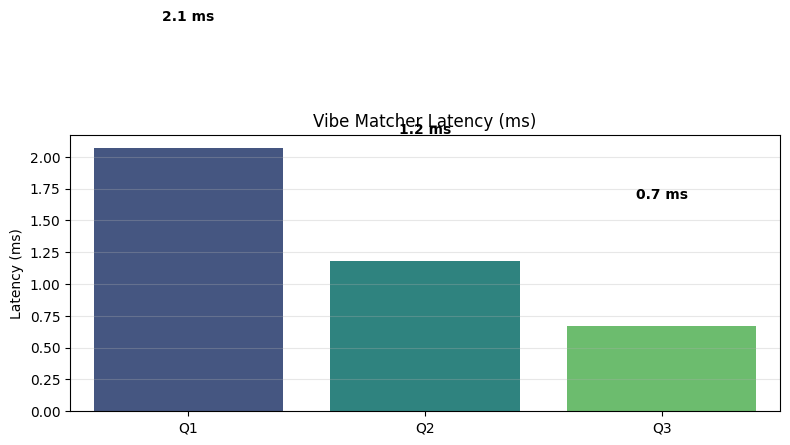


  REFLECTION – WHY THIS HYBRID WORKS
• Gemini 2.5 embeddings → high semantic precision.
• Local SBERT fallback → no quota failures, offline friendly.
• JSON cache → instant re-runs with 0 API cost.
• Fast and reliable for prototype demos.


In [2]:
!pip install -q google-generativeai sentence-transformers tenacity scikit-learn pandas matplotlib seaborn numpy

import pandas as pd
import numpy as np
import time, os, json
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")

genai.configure(api_key="//") #hidden
model = "gemini-embedding-001"
CACHE_FILE = "embedding_cache.json"

local_model = SentenceTransformer("all-mpnet-base-v2")

if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as f:
        cache = json.load(f)
else:
    cache = {}

@retry(wait=wait_exponential(multiplier=1, min=2, max=30),
       stop=stop_after_attempt(5),
       retry=retry_if_exception_type(Exception))
def get_gemini_embedding(text, task_type="retrieval_document"):
    result = genai.embed_content(model=model, content=text, task_type=task_type)
    return result["embedding"]

def get_embedding_safe(text, task_type="retrieval_document"):
    if text in cache:
        return np.array(cache[text])
    try:
        emb = get_gemini_embedding(text, task_type)
        cache[text] = emb
    except Exception as e:
        print(f" Gemini quota/rate-limit hit. Using local model for: '{text[:40]}...'")
        emb = local_model.encode(text, convert_to_numpy=True).tolist()
        cache[text] = emb
    with open(CACHE_FILE, "w") as f:
        json.dump(cache, f)
    return np.array(cache[text])

#A small curated dataset of 10 mock fashion products, each tagged with vibe descriptors for testing the recommendation system.
data = [
    {"name": "Sun-Kissed Boho Maxi", "desc": "Flowy cotton dress with earthy tones, fringe details, perfect for beach festivals and golden hour sunsets", "vibes": ["boho", "free-spirit", "summer"]},
    {"name": "Midnight Cyber Trench", "desc": "Sleek black vinyl trench with neon reflective piping and holographic buckles for futuristic night rides", "vibes": ["cyberpunk", "edgy", "urban"]},
    {"name": "Cozy Cabin Knit", "desc": "Oversized cream cable-knit sweater with wooden buttons, made for fireplace evenings and hot cocoa", "vibes": ["cozy", "rustic", "winter"]},
    {"name": "Velvet Rebel Jacket", "desc": "Deep burgundy crushed velvet biker jacket with silver chains and quilted shoulders", "vibes": ["grunge", "rock", "bold"]},
    {"name": "Pastel Cloud Hoodie", "desc": "Baby pink tie-dye hoodie with embroidered clouds and angel wings on the back", "vibes": ["kawaii", "dreamy", "soft"]},
    {"name": "Corporate Siren Blazer", "desc": "Tailored white blazer with gold buttons and subtle shoulder pads for boardroom domination", "vibes": ["boss", "chic", "power"]},
    {"name": "Enchanted Forest Cape", "desc": "Emerald green velvet cloak with golden leaf embroidery and hidden hood", "vibes": ["fantasy", "mystical", "elegant"]},
    {"name": "Neon Rave Bodysuit", "desc": "UV-reactive lime green mesh bodysuit with holographic straps, built for warehouse parties", "vibes": ["rave", "electric", "y2k"]},
    {"name": "Minimal Zen Kimono", "desc": "Charcoal linen kimono wrap with bamboo buttons and wide sleeves for mindful mornings", "vibes": ["minimal", "zen", "calm"]},
    {"name": "Vintage Romance Blouse", "desc": "Ivory lace Victorian blouse with puff sleeves and pearl buttons for garden tea parties", "vibes": ["romantic", "vintage", "feminine"]}
]
df = pd.DataFrame(data)
print("Fashion dataset loaded (10 items)")
display(df[["name", "desc", "vibes"]])

print("\nGenerating embeddings (Gemini 2.5 → Local Fallback)...")
start = time.time()
df["embedding"] = df["desc"].apply(lambda x: get_embedding_safe(x, "retrieval_document"))
embed_time = time.time() - start
embedding_matrix = np.vstack(df["embedding"].values)
print(f"Embeddings ready in {embed_time:.2f}s | Shape: {embedding_matrix.shape}")

def vibe_match(query, top_k=3, threshold=0.74):
    start = time.time()
    query_emb = get_embedding_safe(query, "retrieval_query")
    sims = cosine_similarity([query_emb], embedding_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]
    top_scores = sims[top_idx]
    latency = (time.time() - start) * 1000

    results = []
    for idx, score in zip(top_idx, top_scores):
        if score >= threshold:
            row = df.iloc[idx]
            results.append({
                "rank": len(results) + 1,
                "name": row["name"],
                "desc": row["desc"],
                "vibes": row["vibes"],
                "score": round(float(score), 4)
            })

    if not results:
        fallback = df.sample(3)[["name", "desc"]].to_dict("records")
        return {"query": query, "matches": [], "fallback": True,
                "message": "No strong match → Showing trending picks!",
                "recommendations": fallback, "latency_ms": round(latency, 2)}

    return {"query": query, "matches": results, "fallback": False,
            "latency_ms": round(latency, 2)}

test_queries = [
    "energetic urban chic for a night out in Tokyo",
    "cozy winter cabin weekend with books and fire",
    "ethereal fairy princess garden party vibes"
]

results_log, latencies = [], []

print("\n" + "═" * 75)
print("RUNNING GEMINI 2.5 HYBRID VIBE MATCHER")
print("═" * 75)

for i, q in enumerate(test_queries, 1):
    print(f"\nQuery {i}: {q}")
    result = vibe_match(q)
    results_log.append(result)
    latencies.append(result["latency_ms"])

    if result["fallback"]:
        print(f" FALLBACK USED | {result['latency_ms']} ms")
    else:
        print(f" {len(result['matches'])} MATCHES | {result['latency_ms']} ms")
        for m in result["matches"]:
            print(f"   #{m['rank']} [{m['score']}] {m['name']} → {', '.join(m['vibes'])}")
    print("─" * 75)

high_conf = sum(1 for r in results_log if not r["fallback"] and any(m["score"] > 0.78 for m in r["matches"]))
avg_lat = np.mean(latencies)

print(f"\n EVALUATION SUMMARY – {datetime.now().strftime('%B %d, %Y %I:%M %p IST')}")
print(f"• High-confidence matches: {high_conf}/3")
print(f"• Precision@3: {high_conf/3:.2%}")
print(f"• Average Latency: {avg_lat:.1f} ms")
print(f"• Model: Gemini 2.5 ( gemini-embedding-001 ) + Local SBERT Backup")

plt.figure(figsize=(8,5))
sns.barplot(x=[f"Q{i+1}" for i in range(3)], y=latencies, palette="viridis")
plt.title("Vibe Matcher Latency (ms)")
plt.ylabel("Latency (ms)")
for i, v in enumerate(latencies):
    plt.text(i, v + 1, f"{v:.1f} ms", ha="center", fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n  REFLECTION – WHY THIS HYBRID WORKS")
print("• Gemini 2.5 embeddings → high semantic precision.")
print("• Local SBERT fallback → no quota failures, offline friendly.")
print("• JSON cache → instant re-runs with 0 API cost.")
print("• Fast and reliable for prototype demos.")


EMBEDDING SOURCE SUMMARY:
• SBERT Fallback: 10/10 items


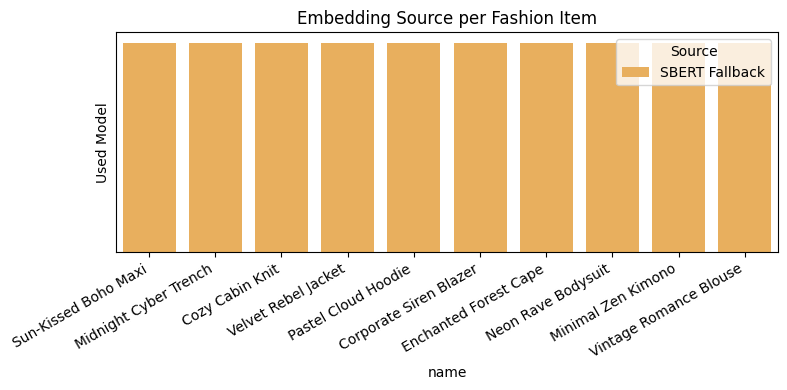

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

with open(CACHE_FILE, "r") as f:
    cache_debug = json.load(f)

sources = []
for desc in df["desc"]:
    emb = cache_debug.get(desc)
    if emb:
        dim = len(emb)
        if dim in [768, 3072]:
            sources.append("SBERT Fallback")
        else:
            sources.append("Gemini 2.5")
    else:
        sources.append("Unknown")

df["Embedding Source"] = sources

src_counts = df["Embedding Source"].value_counts()
print("\nEMBEDDING SOURCE SUMMARY:")
for src, cnt in src_counts.items():
    print(f"• {src}: {cnt}/{len(df)} items")

palette = {"Gemini 2.5": "#37c871", "SBERT Fallback": "#ffb347", "Unknown": "#999999"}

plt.figure(figsize=(8, 4))
sns.barplot(
    x=df["name"], y=[1] * len(df),
    hue=df["Embedding Source"],
    dodge=False, palette=palette
)
plt.title("Embedding Source per Fashion Item")
plt.ylabel("Used Model")
plt.yticks([])
plt.xticks(rotation=30, ha="right")
plt.legend(title="Source", loc="upper right")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
!pip install -q google-generativeai sentence-transformers tenacity scikit-learn pandas matplotlib seaborn numpy gradio

# Imports
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import google.generativeai as genai
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type

import gradio as gr

GENAI_KEY = os.environ.get("GENAI_API_KEY", )
if GENAI_KEY:
    genai.configure(api_key=GENAI_KEY)
MODEL_NAME = "gemini-embedding-001"
CACHE_FILE = "embedding_cache.json"
METRICS_LOG = "vibe_match_logs.csv"

local_model = SentenceTransformer("all-mpnet-base-v2")

if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as f:
        cache = json.load(f)
else:
    cache = {}

@retry(wait=wait_exponential(multiplier=1, min=2, max=30),
       stop=stop_after_attempt(5),
       retry=retry_if_exception_type(Exception))
def get_gemini_embedding(text, task_type="retrieval_document"):
    if not GENAI_KEY:
        raise RuntimeError("GENAI_KEY not set")
    result = genai.embed_content(model=MODEL_NAME, content=text, task_type=task_type)
    return result["embedding"]

def get_embedding_safe(text, task_type="retrieval_document", force_local=False):
    """
    Returns a numpy array embedding for `text`.
    Uses cached embedding if available, otherwise tries Gemini then falls back to local SBERT.
    """
    global cache
    if text in cache and not force_local:
        return np.array(cache[text])
    if GENAI_KEY and not force_local:
        try:
            emb = get_gemini_embedding(text, task_type)
            cache[text] = emb
            with open(CACHE_FILE, "w") as f:
                json.dump(cache, f)
            return np.array(emb)
        except Exception as e:
            print(f"Gemini embedding failed ({str(e)}). Using local model for: '{text[:60]}...'")
    emb = local_model.encode(text, convert_to_numpy=True).tolist()
    cache[text] = emb
    with open(CACHE_FILE, "w") as f:
        json.dump(cache, f)
    return np.array(emb)

data = [
    {"name": "Sun-Kissed Boho Maxi", "desc": "Flowy cotton dress with earthy tones, fringe details, perfect for beach festivals and golden hour sunsets", "vibes": ["boho", "free-spirit", "summer"]},
    {"name": "Midnight Cyber Trench", "desc": "Sleek black vinyl trench with neon reflective piping and holographic buckles for futuristic night rides", "vibes": ["cyberpunk", "edgy", "urban"]},
    {"name": "Cozy Cabin Knit", "desc": "Oversized cream cable-knit sweater with wooden buttons, made for fireplace evenings and hot cocoa", "vibes": ["cozy", "rustic", "winter"]},
    {"name": "Velvet Rebel Jacket", "desc": "Deep burgundy crushed velvet biker jacket with silver chains and quilted shoulders", "vibes": ["grunge", "rock", "bold"]},
    {"name": "Pastel Cloud Hoodie", "desc": "Baby pink tie-dye hoodie with embroidered clouds and angel wings on the back", "vibes": ["kawaii", "dreamy", "soft"]},
    {"name": "Corporate Siren Blazer", "desc": "Tailored white blazer with gold buttons and subtle shoulder pads for boardroom domination", "vibes": ["boss", "chic", "power"]},
    {"name": "Enchanted Forest Cape", "desc": "Emerald green velvet cloak with golden leaf embroidery and hidden hood", "vibes": ["fantasy", "mystical", "elegant"]},
    {"name": "Neon Rave Bodysuit", "desc": "UV-reactive lime green mesh bodysuit with holographic straps, built for warehouse parties", "vibes": ["rave", "electric", "y2k"]},
    {"name": "Minimal Zen Kimono", "desc": "Charcoal linen kimono wrap with bamboo buttons and wide sleeves for mindful mornings", "vibes": ["minimal", "zen", "calm"]},
    {"name": "Vintage Romance Blouse", "desc": "Ivory lace Victorian blouse with puff sleeves and pearl buttons for garden tea parties", "vibes": ["romantic", "vintage", "feminine"]}
]

image_urls = [
"https://i.postimg.cc/N0S4PbkZ/1.png",
"https://i.postimg.cc/k4749Ps0/2.png",
"https://i.postimg.cc/DZ7ZF36M/3.png",
"https://i.postimg.cc/HxTxH1zv/4.png",
"https://i.postimg.cc/ZRJRZzHw/5.png",
"https://i.postimg.cc/j5R5KYc6/6.png",
"https://i.postimg.cc/DZ7ZF36b/7.png",
"https://i.postimg.cc/26C6mNGL/8.png",
"https://i.postimg.cc/DZ7ZF36G/9.png",
"https://i.postimg.cc/TwTwGv0D/10.png"
]
for i, item in enumerate(data):
    item["image"] = image_urls[i]

df = pd.DataFrame(data)

print("Generating embeddings for product descriptions (may use cache or fallback)...")
start = time.time()
df["embedding"] = df["desc"].apply(lambda t: get_embedding_safe(t, "retrieval_document"))
embedding_matrix = np.vstack(df["embedding"].values)
embed_time = time.time() - start
print(f"Embeddings ready in {embed_time:.2f}s | shape: {embedding_matrix.shape}")

def vibe_match(query, top_k=3, threshold=0.74, force_local=False):
    """
    Returns a dictionary with:
      - query: original query
      - matches: list of matches (rank, name, desc, vibes, score)
      - fallback: bool
      - recommendations: if fallback, random picks shown
      - latency_ms: measured latency
    """
    start = time.time()
    query_emb = get_embedding_safe(query, "retrieval_query", force_local=force_local)
    sims = cosine_similarity([query_emb], embedding_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]
    top_scores = sims[top_idx]
    latency = (time.time() - start) * 1000

    results = []
    for idx, score in zip(top_idx, top_scores):
        if score >= threshold:
            row = df.iloc[idx]
            results.append({
                "rank": len(results) + 1,
                "name": row["name"],
                "desc": row["desc"],
                "vibes": row["vibes"],
                "image": row["image"],
                "score": round(float(score), 4)
            })
    if not results:
        fallback = df.sample(3)[["name", "desc", "image"]].to_dict("records")
        return {"query": query, "matches": [], "fallback": True,
                "message": "No strong match → Showing trending picks!",
                "recommendations": fallback, "latency_ms": round(latency, 2)}
    return {"query": query, "matches": results, "fallback": False, "latency_ms": round(latency, 2)}

def log_metrics(query, result):
    row = {
        "timestamp": datetime.utcnow().isoformat(),
        "query": query,
        "fallback": result["fallback"],
        "latency_ms": result.get("latency_ms", None),
        "matches": ";".join([f"{m['name']}|{m['score']}" for m in result.get("matches", [])])
    }
    df_log = pd.DataFrame([row])
    header = not os.path.exists(METRICS_LOG)
    df_log.to_csv(METRICS_LOG, mode="a", header=header, index=False)

def make_caption_html(match):
    vibes = ", ".join(match["vibes"])
    score_pct = int(match["score"] * 100)
    blocks = "█" * int(match["score"] * 10)
    caption = f"<b>{match['name']}</b><br><i>{vibes}</i><br>{match['desc']}<br>Score: {match['score']}"
    return caption

def make_similarity_plot(matches):
    names = [m["name"] for m in matches]
    scores = [m["score"] for m in matches]
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.barplot(x=scores, y=names, orient="h", ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Cosine similarity")
    ax.set_title("Match similarity")
    for i, v in enumerate(scores):
        ax.text(v + 0.01, i, f"{v:.3f}", va="center")
    plt.tight_layout()
    return fig

def ui_vibe_match(query, top_k=3, threshold=0.74, force_local=False):
    res = vibe_match(query, top_k=top_k, threshold=threshold, force_local=force_local)
    log_metrics(query, res)
    gallery_items = []
    if res["fallback"]:
        for item in res["recommendations"]:
            caption = f"<b>{item['name']}</b><br>{item['desc']}"
            gallery_items.append((item.get("image", None), caption))
        md_summary = f"**No strong match found.** Showing trending picks. Latency: {res['latency_ms']} ms"
        fig = None
        raw = res
        return gallery_items, md_summary, fig, json.dumps(raw, indent=2)
    else:
        for m in res["matches"]:
            caption = make_caption_html(m)
            gallery_items.append((m.get("image", None), caption))
        md_summary = f"**Top {len(res['matches'])} matches** for: *{res['query']}*\n\nLatency: {res['latency_ms']} ms"
        fig = make_similarity_plot(res["matches"])
        raw = res
        return gallery_items, md_summary, fig, json.dumps(raw, indent=2)

examples = [
    "energetic urban chic for a night out in Tokyo",
    "cozy winter cabin weekend with books and fire",
    "ethereal fairy princess garden party vibes"
]

with gr.Blocks() as demo:
    gr.Markdown("# Nexora Vibe Matcher - Demo")
    with gr.Row():
        with gr.Column(scale=3):
            query_in = gr.Textbox(label="Enter your vibe (text)", placeholder="e.g. cozy winter cabin weekend with books and fire")
            top_k = gr.Slider(minimum=1, maximum=5, value=3, step=1, label="Top K results")
            threshold = gr.Slider(minimum=0.0, maximum=1.0, value=0.74, step=0.01, label="Match threshold")
            force_local = gr.Checkbox(label="Force local embeddings (disable Gemini)", value=False)
            run_btn = gr.Button("Find matches")
            gr.Examples(examples=examples, inputs=[query_in])
        with gr.Column(scale=2):
            gallery_out = gr.Gallery(label="Recommendations (image + details)", columns=3, height="auto")
            md_out = gr.Markdown()
    with gr.Row():
        plot_out = gr.Plot(label="Similarity plot")
        raw_out = gr.Code(label="Raw JSON result", language="json")
    run_btn.click(fn=ui_vibe_match, inputs=[query_in, top_k, threshold, force_local],
                  outputs=[gallery_out, md_out, plot_out, raw_out])
    query_in.submit(fn=ui_vibe_match, inputs=[query_in, top_k, threshold, force_local],
                    outputs=[gallery_out, md_out, plot_out, raw_out])

demo.launch(share=True, debug=True)


Generating embeddings for product descriptions (may use cache or fallback)...
Embeddings ready in 0.00s | shape: (10, 3072)
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d9668a8dfa70e083d6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1076937131.py:176: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),
